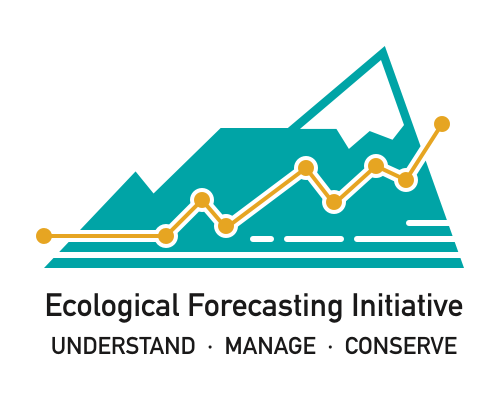

# Learn to Forecast Beetle Communities

## Introduction - why forecast beetles?

Biodiversity monitoring is critical for understanding environmental quality, evaluating the sustainability of land-use practices, and forecasting future impacts of global change on ecosystems. Sentinel species give forewarning of environmental risk to humans, so are particularly useful for such monitoring and forecasting efforts because they can provide surrogates for other co-located components of biodiversity (Sauberer et al. 2004).

Ground beetles (Family: Carabidae) are appropriate candidates for biodiversity monitoring and ecological forecasting as they are well-studied sentinel species that are geographically widespread, and their community dynamics are particularly congruent with the diversity of other invertebrates (Holland 2002; Lundgren & McCravy 2011; Bousquet 2012; Hoekman et al. 2017). Read more about forecasting beetles [here](https://projects.ecoforecast.org/neon4cast-docs/Beetles.html).


|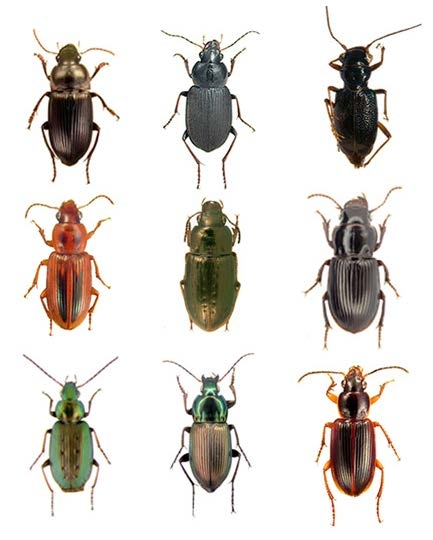|
|:---:|
|Ground Beetles of Eastern North Carolina Agriculture, [NC State Extension](https://content.ces.ncsu.edu/the-ground-beetles-of-eastern-north-carolina-agriculture)|

## What is NEON Forecasting Challenge?

The Challenge has been organized by the Ecological Forecasting Initiative Research Coordination Network ([EFI RCN](https://ecoforecast.org/)).

The Challenge asks the scientific community to produce ecological forecasts of future observations of ecological data that will be collected and published by the National Ecological Observatory Network (NEON). The Challenge is split into five themes that span aquatic and terrestrial systems, and population, community, and ecosystem processes across a broad range of ecoregions. We are excited to use this Challenge to learn more about the predictability of ecological processes by forecasting NEON data before it is collected.

Which modeling frameworks, mechanistic processes, and statistical approaches best capture community, population, and ecosystem dynamics? These questions are answerable by a community generating a diverse array of forecasts. The Challenge is open to any individual or team from anywhere around the world that wants to submit forecasts. Learn more about how you can participate here.

## What are we forecasting in this workshop?

What: Forecast abundance and/or richness of ground beetles (carabids) collected in pitfall traps, standardized to sampling effort (trap night). More information about the NEON data product (DP1.10022.001, Ground beetles sampled from pitfall traps) we are forecasting can be found [here](https://data.neonscience.org/data-products/DP1.10022.001). Note that we are not downloading the target dataset from the NEON data portal. Rather, we will download a version of the dataset that has been simplified and preformatted for this challenge by the EFI RCN. An example script to preformat the target data from the EFI RCN can be found [here](https://github.com/eco4cast/neon4cast/blob/465e39d6a0fd78e1deebedbb50cfaee5bd018406/notebook/beetles_example.R). Specifically, the targets are:

- **Abundance:** is the total number of carabid individuals per trap-night, estimated each week of the year at each NEON site.

- **Richness:** is the total number of unique species in a sampling bout for each NEON site each week.

Where: 47 terrestrial NEON sites that span the diverse ecosystems of the U.S.

For this tutorial, we are going to focus on the NEON site at Ordway-Swisher Biological Station ([OSBS](https://www.neonscience.org/field-sites/osbs)), which is located in Domain 03 (D03) in Florida.



If you're interested to learn more about downloading and exploring NEON data beyond beetles at OSBS, follow [this link](https://www.neonscience.org/resources/learning-hub/tutorials/neondatastackr) to get an overview of NEON's data products, how to download the data, and how to interact visualize and analyze the data.


---

This is a google colab notebook, similar to Jupyter notebook. To get started, make a copy of this file or start a new file that you can edit.

Go to File > Save a copy in Drive

In Notebooks, you can write code or text using these 'chunks'. To start a new chunk, you canc click one of the + in the upper left, or hover at the bottom of the current chunk and click +

To start, we recommend running the first code chunk 10-15 minutes before joining the zoom. It may take a few minutes to bring these packages in depending on your browser and cache.

In [ ]:
# tidyverse package for tidying, wrangling, visualizing data
if(!require("tidyverse")) install.packages("tidyverse")

# lubridate, which is part of tidyverse, makes handling dates easier
if(!require("lubridate")) install.packages("lubridate")

# tsibble package for tidy temporal data
install.packages('tsibble')

# fable package for forecasting models for tidy time series
install.packages('fable')

# neon4cast used for formatting with function efi_format(), for submitting forecast
remotes::install_github("eco4cast/neon4cast")

# score4cast is for scoring model
devtools::install_github("eco4cast/score4cast")

In [1]:
# load packages
library(tidyverse)
library(fabletools)
library(tsibble)
library(fable)
library(neon4cast)
library(score4cast)

# increase the plot width
options(repr.plot.width=15, repr.plot.height=8)

── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 method overwritten by 'tsibble':
  method               from 
  as_tibble.grouped_df dplyr


Attaching package: 'tsibble'


The following object is masked from 'package:lubridate':

    interval


The following objects are masked from 'package:base':

    intersect, setdiff, union




In [2]:
## ----get data from sites------

# site data - see all NEON sites where beetle data is collected 
site_data <- read_csv("https://raw.githubusercontent.com/eco4cast/neon4cast-targets/main/NEON_Field_Site_Metadata_20220412.csv") %>%
   dplyr::filter(beetles == 1)

# beetle targets are here - formatted for this workshop 
url <- "https://sdsc.osn.xsede.org/bio230014-bucket01/challenges/targets/project_id=neon4cast/duration=P1W/beetles-targets.csv.gz"

# Get climate data
path_to_clim_data <- "https://data.cyverse.org/dav-anon/iplant/projects/NEON/ESA2024/forecasting_beetles_workshop/modeled_climate_2012-2050_OSBS_CMCC_CM2_VHR4.csv"

Rows: 81 Columns: 54
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (34): field_domain_id, field_site_id, field_site_name, phenocam_code, ph...
dbl (20): terrestrial, aquatics, phenology, ticks, beetles, field_latitude, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
# choose site
my_site = "OSBS"

# set dates for when we want to start and stop predictions


# read in the table



Rows: 7668 Columns: 6
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): project_id, site_id, duration, variable
dbl  (1): observation
dttm (1): datetime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


project_id,site_id,datetime,duration,variable,observation
<chr>,<chr>,<date>,<chr>,<chr>,<dbl>
neon4cast,OSBS,2013-07-08,P1W,abundance,0
neon4cast,OSBS,2013-07-08,P1W,richness,0
neon4cast,OSBS,2013-07-22,P1W,abundance,0
neon4cast,OSBS,2013-07-22,P1W,richness,0
neon4cast,OSBS,2013-08-05,P1W,abundance,0
neon4cast,OSBS,2013-08-05,P1W,richness,0


Visualize data before proceeding with analysis

In [1]:
# visualze tsibble using autoplot() 

## Create the training dataset

We will train our forecast models on target data from the beginning of the dataset until our `forecast_startdate`, which we set above.

In [2]:
# createt new data frame filtering before start date and using pivot_wider 



## Example forecasts: some simple models

In this tutorial, we will begin by producing two "null model" forecasts using functions available in the `fable` package for R. The `MEAN` null model will forecast abundance based on the historical mean and standard deviation in the training data. The `NAIVE` null model is a random walk model that generates a forecast based on the current observation plus process uncertainty. We will then use the `TSLM` function to create simple linear regression models to predict beetle abundances using daily temperature (mean daily temperature at 2m height) and precipitation (daily cumulative precipitation) estimates produced from CMIP6 climate model runs from 1950-2050. While these data do not represent actual observations of temperature and precipitation at the NEON site, they have been fit to historical data, so past dates in the simulated data should capture general trends at the site and values for future dates should represent a realistic forecast of climate variables into the future.

## Forecast beetle abundance: null models

Here, we fit our two null models to the training data and then create forecasts for 2022-2024. Note that we are using a `log(x + 1)` transform (using the `log1p()` function) for the abundance data in all of our models. This is a common transform for abundance data for communities, which are typically log-normal, but with zeros. We are keeping the model simple for this example, but you could substitute generalized linear regression models, zero-inflated models, or other approaches better model the distribution of beetle abundances.



In [3]:
# specify and fit models

# Using a log(x + 1) transform on the abundance data
# using both MEAN and NAIVE


# make a forecast using forecast function


# visualize forcast
# autoplot is an extension of ggplot2, in this case it recognizes the time series forecast and creates the visualization



## Forecast beetle abundance with regression models

Regression on climate model outputs allows us to make predictions about future field seasons based on CMIP6 projections. We downloaded climate model outputs from https://open-meto.com using the RopenMeto package, which you can install using: `remotes::install_github("FLARE-forecast/RopenMeteo")`. More information about the simulations that produced the climate drivers used in this example can be found [here](https://openmeteo.substack.com/p/climate-change-api).

So we do not overwhelm the open-meteo API, we have made the climate data used in this tutorial available as a [Community Data resource on the CyVerse Data Store](https://de.cyverse.org/data/ds/iplant/home/shared/NEON/ESA2024/forecasting_beetles_workshop?type=folder&resourceId=af152ca6-dc9b-11ee-aacd-90e2ba675364).

The climate data we're using in this example were generated by the CMCC_CM2_VHR4 climate model.

Other predictor variables beyond climate data are appropriate for forecasting. Just remember that the driver data for forecasting are an out-of-sample observation (also forecasted) such that it can be used to generate a prediction of beetle richness and abundance. That is why NEON's meteorological data from OSBS are not used to generate beetle forecasts, as we can only observe up to the current time that the forecast starts. Additionally, the hand-off from directly observed meteorological data to forecasted climate data introduces additional uncertainty to forecasts that we have currently omitted. For the sake of simplicity, we have trained the data on past CMIP6 model projections that have been corrected to the nearest observations and then forecasted with CMIP6's CMCC_CM2_VHR4 model projection ensembles.

In [4]:
# Get climate data

# make a tsibble object


# make wide
# use pivot wider to take values from the prediction column and create new columns for each variable


# visualize climate data, including a marker for our forecast startdate



### Next steps include:

- break climate data into a training set (`clim_past`) and a data set for forecasting (`clim_future`)
- combine the target abundance data with climate to make a training dataset using `left_join` from the `dplyr` package
- specify and fit a simple linear regression model using `fable::TSLM()`
- look at fit stats and identify best model using AIC, where the lowest AIC is the best model
- visualize model fit, using `fabletools::augment()` to format model output as a tsibble for use with ggplot

In [5]:
# subset into past and future datasets, based on forecast_startdate


# combine target and climate data into a training dataset



# preview the training data set


# specify and fit model


# look at fit stats and identify the best model using AIC, where the lowest AIC is the best model


# visualize model fit
# augment reformats model output into a tsibble for easier plotting



## Creating a forecast

We could use all of these models to make an ensemble forecast, but for simplicity, we will just take the best model (lowest AICc), and use that to create a forecast with our future climate dataset.


In [6]:
# focus on temperature model for now


# make a forecast


# filter "future" climate data to target climate model


# visualize the forecast


## Submitting a forecast to the NEON Forecast Challenge

Detailed guidelines on how to submit a forecast to the NEON Forecast Challenge can be found [here](https://projects.ecoforecast.org/neon4cast-ci/instructions.html). The forecast file format requires the following columns:

`project_id`: use "neon4cast"

`model_id`: the short name of the model defined as the model_id in your registration. The model_id should have no spaces. model_id should reflect a method to forecast one or a set of target variables and must be unique to the neon4cast challenge.

`datetime`: forecast timestamp. Format `%Y-%m-%d %H:%M:%S` with UTC as the time zone. Forecasts submitted with a `%Y-%m-%d` format will be converted to a full datetime assuming UTC mid-night.

`reference_datetime`: The start of the forecast; this should be 0 times steps in the future. There should only be one value of `reference_datetime` in the file. Format is `%Y-%m-%d %H:%M:%S` with UTC as the time zone. Forecasts submitted with a `%Y-%m-%d` format will be converted to a full datetime assuming UTC mid-night.

`duration`: the time-step of the forecast. Use the value of `P1D` for a daily forecast, `P1W` for a weekly forecast, and `PT30M` for 30 minute forecast. This value should match the duration of the target variable that you are forecasting. Formatted as ISO 8601 duration

`site_id`: code for NEON site.

`family`: name of the probability distribution that is described by the parameter values in the parameter column (see list below for accepted distribution). An ensemble forecast as a family of ensemble. See note below about family

`parameter`: the parameters for the distribution (see note below about the parameter column) or the number of the ensemble members. For example, the parameters for a normal distribution are called mu and sigma.

`variable`: standardized variable name. It must match the variable name in the target file.

`prediction`: forecasted value for the parameter in the parameter column

To submit our example forecast, we can take the output from the `fabletools::forecast()` function we used above and feed it into `neon4cast::efi_format()` to format the output for submissions to The Challenge. We also need to add a few additional columns.

datetime,site_id,parameter,model_id,family,variable,prediction,project_id,reference_datetime,duration
<date>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
2022-01-01,OSBS,1,bet_abund_example_tslm_temp,ensemble,abundance,0.08170427,neon4cast,2022-01-01,P1W
2022-01-01,OSBS,2,bet_abund_example_tslm_temp,ensemble,abundance,-0.05777970,neon4cast,2022-01-01,P1W
2022-01-01,OSBS,3,bet_abund_example_tslm_temp,ensemble,abundance,0.09526286,neon4cast,2022-01-01,P1W
2022-01-01,OSBS,4,bet_abund_example_tslm_temp,ensemble,abundance,0.03638216,neon4cast,2022-01-01,P1W
2022-01-01,OSBS,5,bet_abund_example_tslm_temp,ensemble,abundance,-0.07788340,neon4cast,2022-01-01,P1W
2022-01-01,OSBS,6,bet_abund_example_tslm_temp,ensemble,abundance,0.05507596,neon4cast,2022-01-01,P1W


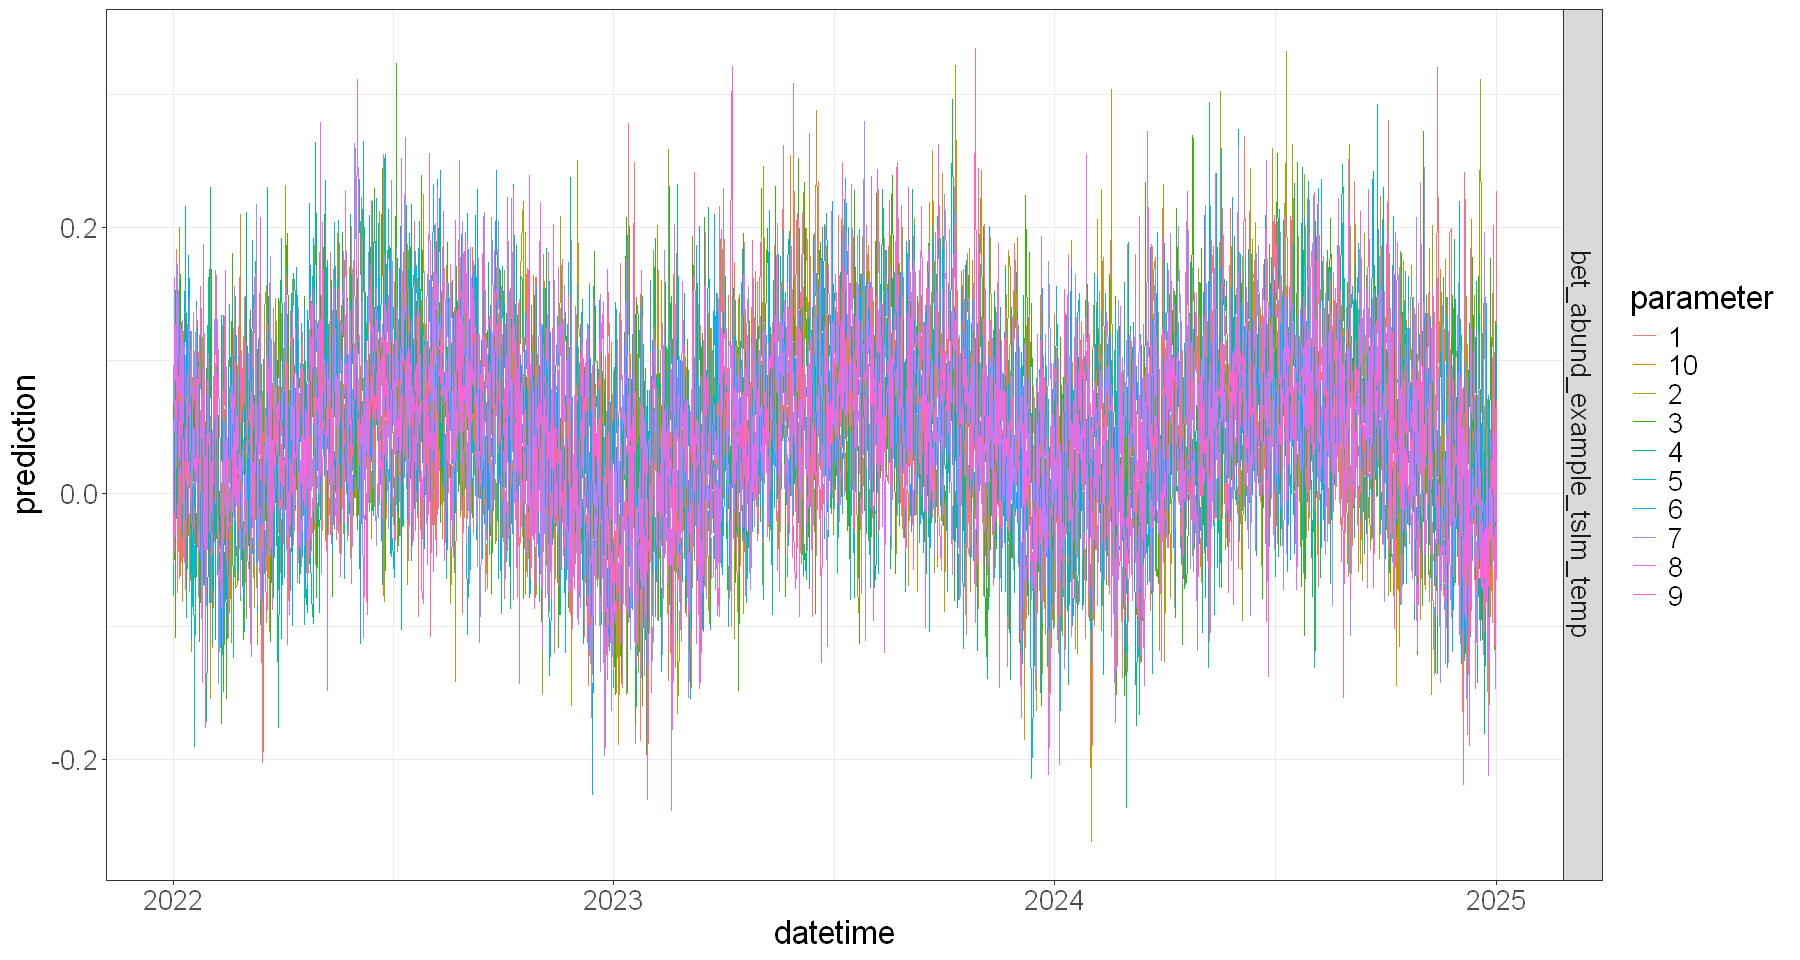

In [13]:
# code to submit

# update dataframe of model output for submission
fc_best_lm_efi <- fc_best_lm %>%
  mutate(site_id = my_site) %>% #efi needs a NEON site ID
  neon4cast::efi_format() %>%
  mutate(
    project_id = "neon4cast",
    model_id = "bet_abund_example_tslm_temp",
    reference_datetime = forecast_startdate,
    duration = "P1W")

# preview EFI format
head(fc_best_lm_efi)

# visualize the EFI-formatted submission




## Scoring your forecast

The Challenge implements methods from the scoringRules R package to calculate the Continuous Rank Probability Score (CRPS) via the `score4cast` package, where a lower CRPS score indicates higher forecast accuracy. CRPS uses information about the variance of the forecasts as well as the estimated mean to calculate the score by comparing it with the observation. There is some balance between accuracy and precision. The forecasts will also be compared with 'null' models (RW and climatology). More information can be found in the documentation or the `score4cast` package from EFI organizers [here](https://github.com/eco4cast/score4cast).

You can view past submissions to the Beetle Communities theme [here](https://projects.ecoforecast.org/neon4cast-dashboard/beetles.html).

For immediate feedback, we can use the targets data from 2022 to score our forecast for the 2022 field season at OSBS.

In [14]:
# filter to 2022 because that is the latest release year
# 2023 is provisional and most sites do not yet have data reported


# list of target site dates for filtering mod predictions


# filter model forecast data to dates where we have observations


# score the forecasts



# get scores for the mean and naive models

# the fc_null object has scores from both models

# note: we need to add site_id back in for efi_format() to work

fc_null_efi <- fc_null %>%
  mutate(site_id = my_site) %>% #efi needs a NEON site ID
  neon4cast::efi_format()



# filter to dates where we have target data from 2022

mod_results_to_score_null <- fc_null_efi %>%
  left_join(target_site_dates_2022,.) %>%
  dplyr::filter(!is.na(parameter))



# score the forecasts for those dates

mod_null_scores <- score4cast::score(
  forecast = mod_results_to_score_null,
  target = targets_2022)



# stack the scores for our best_lm and the null models

# forcing reference_datetime to be the same type in both tables

# so they will stack

all_mod_scores <- bind_rows(
  mod_null_scores %>% mutate(
    reference_datetime = as.character(reference_datetime)),
  mod_scores %>% mutate(
    reference_datetime = as.character(reference_datetime)))

site_id,datetime
<chr>,<date>
OSBS,2022-05-30
OSBS,2022-06-13
OSBS,2022-06-27
OSBS,2022-08-08


Joining with `by = join_by(site_id, datetime)`


model_id,reference_datetime,site_id,datetime,family,variable,observation,crps,logs,mean,median,sd,quantile97.5,quantile02.5,quantile90,quantile10,horizon
<chr>,<chr>,<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<drtn>
bet_abund_example_tslm_temp,2022-01-01,OSBS,2022-05-30,sample,abundance,0.13333333,0.05634733,-1.067613,0.05007946,0.05732437,0.05042120,0.1195458,-0.01608966,0.1108714,-0.01539387,149 days
bet_abund_example_tslm_temp,2022-01-01,OSBS,2022-06-13,sample,abundance,0.04761905,0.01455855,-1.973402,0.06746804,0.06497179,0.06446115,0.1904231,-0.01095242,0.1724734,-0.00776521,163 days
bet_abund_example_tslm_temp,2022-01-01,OSBS,2022-06-27,sample,abundance,0.26190476,0.18339283,8.576470,0.05302256,0.06162009,0.04786250,0.1265434,-0.01632325,0.1158733,-0.01391165,177 days
bet_abund_example_tslm_temp,2022-01-01,OSBS,2022-08-08,sample,abundance,0.16904762,0.03716454,-1.149272,0.12110858,0.11417302,0.07657296,0.2342636,0.02142464,0.2330354,0.02821103,219 days


Joining with `by = join_by(site_id, datetime)`
Joining with `by = join_by(model_id, site_id, variable)`


## Visualize forecast scores

Before we visualize the scores, we can visualize the target 2022 observations and compare them against the forecast ensembles (parameters) among all three models. Each individual line in the figure below represents a single forecast ensemble and all the lines together represents the forecast's uncertainty. The points represent the direct observed target data and assumes there is no uncertainty.


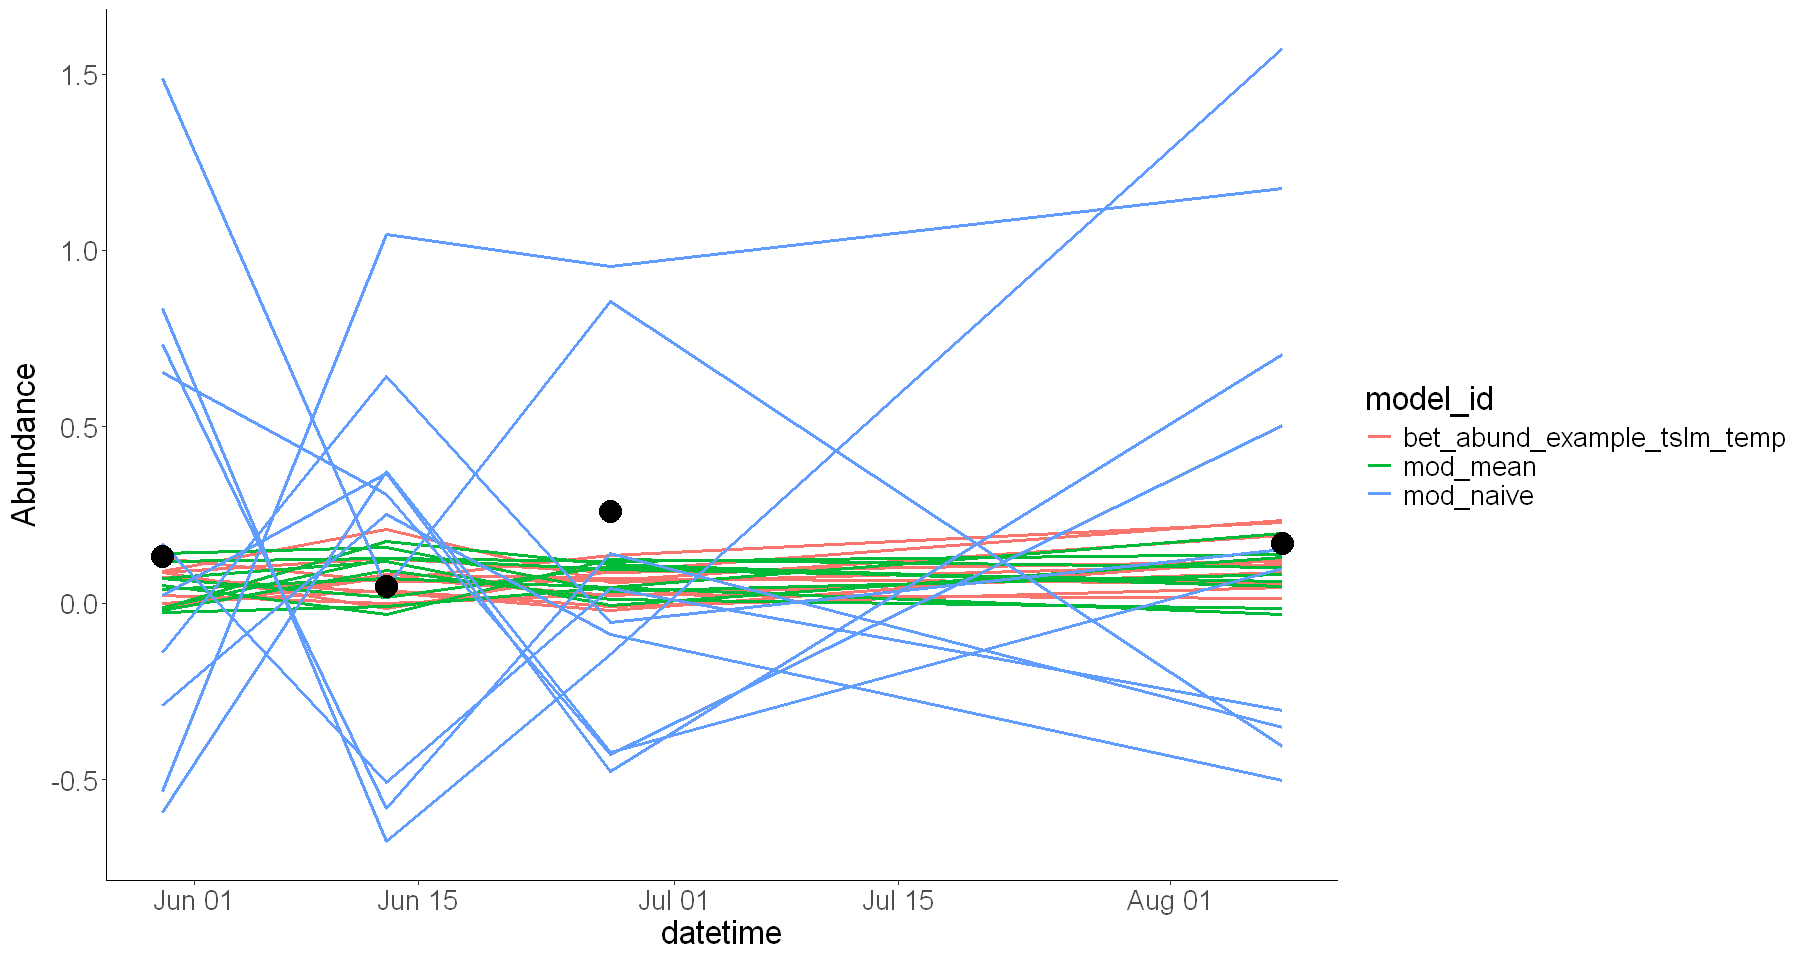

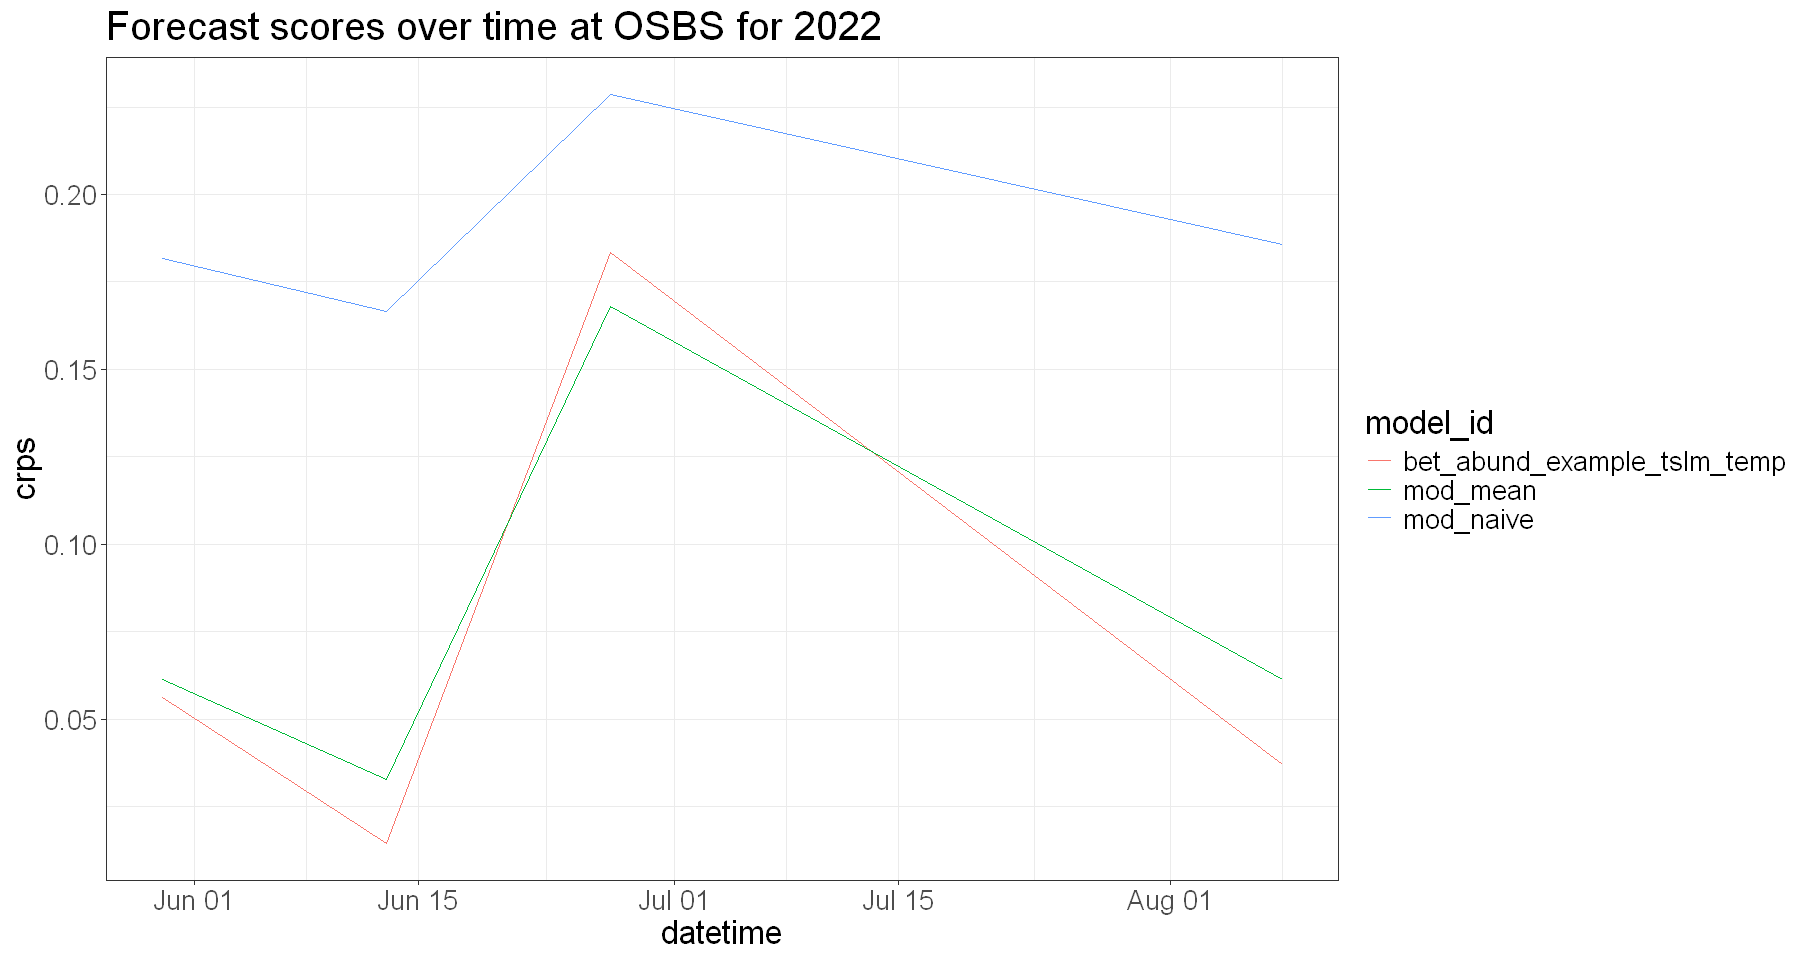

In [15]:
mod_results_to_score_lm <- mod_results_to_score_lm |> select(site_id,datetime,parameter,model_id,family,variable,prediction)


# Compare Forecasts to Raw Data. Ensemble forecasts are the lines and the black circles are the direct observations.

rbind(mod_results_to_score_null,mod_results_to_score_lm) %>%
  ggplot(., aes(datetime, prediction, color = model_id, group=interaction(parameter, model_id))) +
  geom_line(lwd = 1)+
  geom_point(aes(datetime, observation), color = "black", size = 6, inherit.aes = F, data = targets_2022)+
  ylab("Abundance")+
  theme_classic() +
    theme(text=element_text(size=20))

#  plot the scores. Remember, lower scores indicate better forecast accuracy.

all_mod_scores %>%
  ggplot(aes(datetime, crps, color = model_id)) +
  geom_line() +
  theme_bw() +
  theme() +
    theme(text=element_text(size=20)) +
    ggtitle("Forecast scores over time at OSBS for 2022")

## Option to submit your forecast

Lastly, if you feel so inclined, you can submit your forecast outputs file as an entry to The Challenge to be scored. If you want to submit a file, you will (1) need to register your model and (2) you cannot have the word "example" in your filename or model_id. In the example below, we are including the "example" text string in the file and model names so it is not evaluated as part of the challenge.

In [ ]:
# file name format is: theme_name-year-month-day-model_id.csv


# set the theme name

theme_name <- "beetles"


# set your submission date

file_date <- Sys.Date()



# make sure the model_id in the filename matches the model_id in the data

# NOTE: having the text string "example" in the file name will prevent this

# submission from being displayed on the challenge dashboard or being included

# in statistics about challenge participation.

efi_model_id <- "bet_abund_example_tslm_temp"



# format the file name

forecast_file <- paste0(theme_name,"-",file_date,"-",efi_model_id,".csv.gz")



# write the file to your working directory

write_csv(fc_best_lm_efi, forecast_file)



# submit the file

neon4cast::submit(forecast_file = forecast_file)

## What's next?

- The forecasts we created here were relatively simple. What are ideas you have to improve the forecasts?
- How could you expand on this forecasting exercise? More sites? Different forecast horizons?
- How could you apply what you have learned here in your research or teaching?

### Acknowledgements

This tutorial is based in part off of tutorials created by Freya Olsson for the [NEON Forecast Challenge Workshop](https://github.com/OlssonF/NEON-forecast-challenge-workshop/tree/main) and examples created by Carl Boettiger for the [Beetle Communities theme documentation](https://github.com/cboettig/neon-beetles-forecasts/tree/main).

See the full tutorial and download the R file [here](https://www.neonscience.org/resources/learning-hub/tutorials/neon-beetle-forecasting).